In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_prediction import Replicator
from pneumococcus_data import data_observation
from compute_dynamics import *
from Jacobian import jacobian_func

# import Particle Swarm Optimization algorithm
from PSO_algo import Particle
from PSO_algo import PSO

### Description
The number of serotypes reported in Brazil is $n=26$ and $\mu = 9.85$. \
We start by estimating the matrix $26 \times 26$ $\left(\alpha_{ij}\right)$ of Brazil. \
Since $\mu$ of Brazil is large, we estimate parameters such that the Brazil serotype frequencies correspond to the solution of the replicator dynamics at time $\tau=50$ with the same frequencies for all initial values $z_i(0)=1/n$, $1 \leq i \leq 26$. The target function for PSO algorithm satisfies that: \
i) First, from $\alpha_{ij}$'s estimated from Nepal, we insert as fixed the $\alpha_{ij}$'s values already estimated for the serotype pairs common between the two sites. \
ii) Then we apply the PSO algorithm in the range $\left[-10, 10\right]$ to estimate the remaining $147$ $\alpha_{ij}$'s such that the error between data observation $z^*_{\text{Brazil}}$ and the solution of replicator dynamics (corresponding to $\Lambda$ matrix calculated from $\left(\alpha_{ij}\right)$) at time $\tau =50$ $\mathbf{z}(50)$ attains as low value as possible. \
There are $147$ $\alpha_{ij}$'s estimated.

In [2]:
# data observation from 5 countries
Iran, Denmark, Brazil, Nepal, Mozambique = data_observation()

# import name of serotypes and their frequencies from Brazil
Brazil_strain = np.array(Brazil.strain)
Brazil_cases = np.array(Brazil.cases)

#number of Brazil's serotypes
strain_number = len(Brazil_strain) #=26

#import Nepal alpha & data
Nepal_alpha = np.loadtxt(open("Nepal_alpha.txt","rb"), delimiter=",", skiprows = 0)

In [3]:
# initiate matrix Brazil_alpha
Brazil_alpha = np.ones((strain_number, strain_number))*50

#In Brazil alpha matrix, find the positions of alpha_ij already estimated before in Nepal and fills with these values
for xB, strain_xB in enumerate(Brazil_strain):
    for yB, strain_yB in enumerate(Brazil_strain):
        find_xNepal = np.where(Nepal_strain == strain_xB)
        index_xNepal = find_xNepal[0]

        find_yNepal = np.where(Nepal_strain == strain_yB)
        index_yNepal = find_yNepal[0]

        if index_xNepal.size > 0 and index_yNepal.size > 0:
            Brazil_alpha[xB, yB] = Nepal_alpha[index_xNepal, index_yNepal]

np.savetxt('fix_alpha_Brazil.txt', Brazil_alpha, delimiter = ',')

In [4]:
#find the length of vector that we need to fit the matrix Brazil alpha
length = 0

for i in range(0, strain_number):
    for j in range(0, strain_number):
        if Brazil_alpha[i,j] > 49:
            length += 1

print(length)
#so we need to fit 147 elements in the matrix Brazil

#find the coordinate of missing alpha_ij in Brazil alpha_matrix
position = []

for i in range (0, strain_number):
    for j in range (0, strain_number):
        if Brazil_alpha[i,j] > 49:
            position.append(np.array([i,j]))

147


In [5]:
#ratio of single to co-colonization prevalence: mu value of Brazil
mu = 9.85

#initial value
u0 = (1/strain_number)*np.ones(strain_number)

#cost function for optimization process
def func(vector):
    # insert alpha vector to Brazil_alpha
    alpha_matrix = np.loadtxt(open("fix_alpha_Brazil.txt","rb"), delimiter = ",", skiprows = 0)

    for i in range (0, length):
        coordinate = position[i]
        alpha_matrix[coordinate[0], coordinate[1]] = vector[i]

    #compute invasion fitness matrix
    lambd = np.zeros((strain_number, strain_number))
    for i in range (0, strain_number):
        for j in range (0, strain_number):
            lambd[i][j] = mu*(alpha_matrix[j][i] - alpha_matrix[i][j]) + alpha_matrix[j][i] - alpha_matrix[j][j]

    # compute the predicted frequencies, i.e. the solution of replicator equations at t = 50
    solution = Replicator(strain_number, lambd, 50, u0)
    # compute the error between observation data and predictied prevalence
    err = np.linalg.norm(solution - Brazil_cases)

    return err

In [ ]:
# RUN PSO algo
# initial starting location [x1,x2...]

initial = [0]*length
#print(func(initial))

#time consuming: 2h
# input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
bounds = []
for i in range (0, length):
    bounds.append(np.array([-10, 10]))
bounds = np.array(bounds)

#run the algorithm
PSO(func, initial, bounds, num_particles = 200, maxiter = 2000)

FINAL:
[0.6401009314619375, -0.13808968774150587, -0.40837536286645576, -1.8514060291199352, 1.8865645134954545, -0.926307556938932, -1.4898179854290579, -1.492457368182828, 1.5299924064893327, 0.13273272308943448, -2.023668874772821, 1.8775435776998055, 0.28760583676821444, -0.5010232527252445, -0.4198185217635896, 2.4084487066570124, 0.2867795028567049, 1.0117334448617044, 0.5312028108982182, -0.7699732613629391, 0.6265842010383127, 0.645668375493088, -0.083829849207133, 0.17406397999655385, 0.0875211644547284, -0.39005953100622603, -2.403054341071208, -2.1677228122290044, 2.8364562672104663, 2.828250660212545, 0.41275299617357364, 0.5587440639480835, -2.0437428371872426, -1.0901668605560881, 2.0229149002183044, 0.18684977777605127, -0.21556217685805285, -0.44904546238466303, 3.48760746570208, 0.24700309773291854, -2.3147163105089152, 0.3012508795744832, 0.6640244655324645, 1.489992967224862, -0.8723203358483085, 0.5736563740829929, 0.3905827550935149, 1.2641045136715812, -1.03832070

In [6]:
#the 147-vector predicted
opti_Brazil =[0.6401009314619375, -0.13808968774150587, -0.40837536286645576, -1.8514060291199352, 1.8865645134954545, -0.926307556938932, -1.4898179854290579, -1.492457368182828, 1.5299924064893327, 0.13273272308943448, -2.023668874772821, 1.8775435776998055, 0.28760583676821444, -0.5010232527252445, -0.4198185217635896, 2.4084487066570124, 0.2867795028567049, 1.0117334448617044, 0.5312028108982182, -0.7699732613629391, 0.6265842010383127, 0.645668375493088, -0.083829849207133, 0.17406397999655385, 0.0875211644547284, -0.39005953100622603, -2.403054341071208, -2.1677228122290044, 2.8364562672104663, 2.828250660212545, 0.41275299617357364, 0.5587440639480835, -2.0437428371872426, -1.0901668605560881, 2.0229149002183044, 0.18684977777605127, -0.21556217685805285, -0.44904546238466303, 3.48760746570208, 0.24700309773291854, -2.3147163105089152, 0.3012508795744832, 0.6640244655324645, 1.489992967224862, -0.8723203358483085, 0.5736563740829929, 0.3905827550935149, 1.2641045136715812, -1.0383207080387362, 1.4040328835335283, -0.43671291795740613, -0.6753333293356678, -0.20939187558838715, 2.8040101778217914, 0.7311479400528833, -0.5636405037832506, 0.7216966514631079, 0.6595486558466191, -0.6725693723886061, -1.0818839881628584, 0.6357807453913915, -1.1081508787894645, -1.9939329335465854, 0.2732325563004373, -1.6447272613443162, 2.3130568205360333, 2.3192714949087714, -0.3742026746950606, 2.5457290486701636, -2.6092026957849046, -2.4079883989962054, 0.03380680824403922, -3.213429933734271, -0.9304215244068079, 0.07849653369781018, 2.447511640489662, -1.087345897219246, -0.23884154753796022, -1.2086524029830508, 0.05635641823036489, -4.1163943775115195, 0.7832527716867251, 0.20990627845165882, -0.6027691732991635, -5.97561902659428, -4.482030663156673, -1.1140607666848463, 1.301710429200278, -0.9914938260425491, -0.014167006663283327, 1.671017661018211, 0.5362142584449744, -1.8503246671297529, -3.4254264417001243, 1.8161426103692506, -1.332887756218446, -2.7862479681625727, 1.2725975823208104, 0.5749361247915665, -0.40690571245454144, 0.5259498537962297, 0.6326758748304363, -2.0557112272626115, 0.07900404675388042, -0.13839633869513612, -0.710635085512524, -1.7276495561732061, 1.2313043481888797, 0.15924316831709517, 0.8875046167294793, -2.6384337890885203, 0.5234927111210471, 0.3786455105891704, -0.677649659238466, 0.7011640029432542, 0.6900375363109253, 2.050813308979452, -0.3017869704532946, 0.1165039949757214, -0.03385697527275116, 1.9169262412619439, -0.941066722024967, -2.118701032510146, 0.40216545571136414, -0.10540796949882641, 0.31688087353979916, 1.5550998573670287, -0.7679214875878053, 0.02527553551464642, 2.425455813841694, -1.230893763486017, -0.5745662726659783, -1.4703764305954825, 0.4490642803048323, 0.19304509917010834, 2.663759392244314, -0.1376297114201858, 0.43221566989263877, -0.7972290550067268, 1.0661277519333638, -1.1876555825694144, -0.021822298482738346, 0.3246681677107329, -0.900009231573719, 2.2242252156178637, -0.28613361298289236, 4.58499967862967]
#load the Brazil alpha matrix which already has the common alpha_ij inserted from Nepal alphas
Brazil_alpha = np.loadtxt(open("fix_alpha_Brazil.txt","rb"), delimiter = ",", skiprows = 0)

#insert 147 alpha_ij predicted in this step
for i in range (0, length):
    coordinate = position[i]
    Brazil_alpha[coordinate[0], coordinate[1]] = opti_Brazil[i]

#save Brazil alpha matrix
np.savetxt('Brazil_alpha.txt', Brazil_alpha, delimiter = ',')

In [3]:
# Test
#import the matrix
Brazil_alpha = np.loadtxt(open("Brazil_alpha.txt","rb"), delimiter = ",", skiprows = 0)
strain_number = len(Brazil_alpha[0,:]) #=26
mu = 9.85
u0 = (1/strain_number)*np.ones(strain_number)

#compute the Lambda invasion fitness
lambd = np.zeros((strain_number, strain_number))
for i in range (0, strain_number):
    for j in range (0, strain_number):
        lambd[i][j] = mu*(Brazil_alpha[j][i] - Brazil_alpha[i][j]) + Brazil_alpha[j][i] - Brazil_alpha[j][j]

# compute the predicted frequencies, i.e. the solution of replicator equations at t = 50
solution = Replicator(strain_number, lambd, 50, u0)
#compute error between observation data and solution of predicted model
err = np.linalg.norm(solution - Brazil_cases)
print('Error estimate: ' + '{}'.format(err)) #the error is valid

Error estimate: 0.012116835073874052


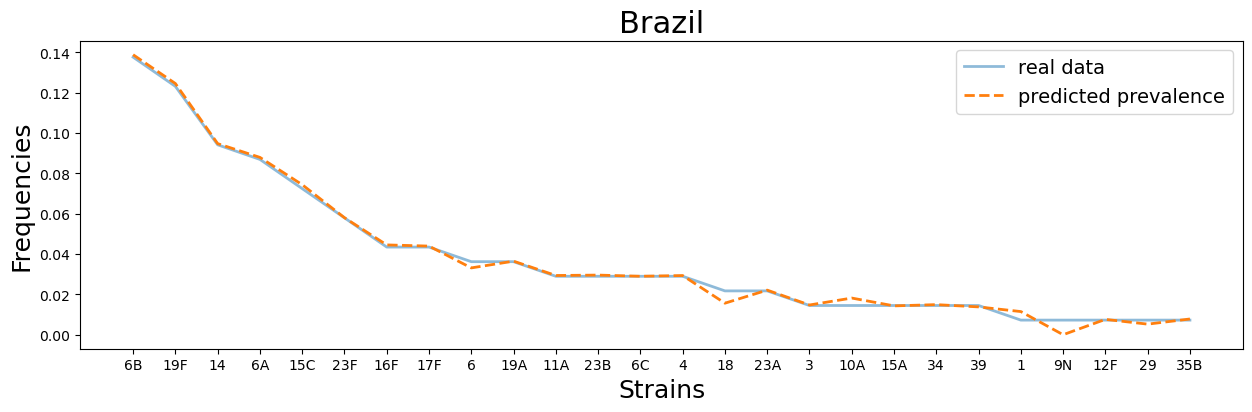

In [7]:
#FINAL TEST by data plot
range_strain = np.linspace(0, strain_number - 1, strain_number)
tick_label = np.array(Brazil.strain)

fig = plt.figure(figsize = (15, 4))
plt.plot(range_strain, Brazil_cases, '-', linewidth = 2, alpha =.5, label = 'real data')
plt.plot(range_strain, solution, '--', linewidth = 2, label = 'predicted prevalence')

plt.xlabel('Strains', fontsize = 18)
plt.ylabel('Frequencies', fontsize = 18)

plt.title('Brazil', fontsize = 22)

plt.xticks(range_strain, labels = tick_label)
plt.legend(fontsize = 14)
plt.show()

### Appendix: Test for equilibrium and its stability

0.012116832498417619


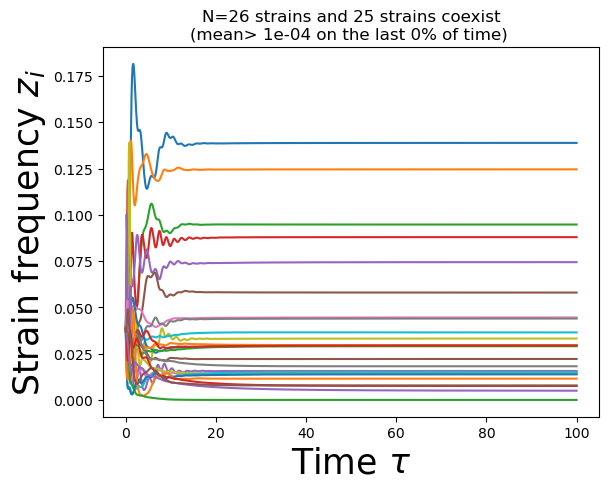

In [9]:
# compute the equilibrium of predicted model
# plot the dynamics
one = np.ones(strain_number) #vector of all ones
result, ax = plot_dynamics(T = 100, mu = 9.85, A = Brazil_alpha, z0 = u0)

mu, A, fit, resultat, nc = simu(T = 50, mu = 9.85, A = Brazil_alpha, z0 = u0)
error = np.linalg.norm(resultat.y[:,-1] - Brazil_cases)
print(error)

In [13]:
# test stable equilibrium?

# test the equilibrium of predicted model
RHS = (np.matmul(lambd, solution) - np.matmul(solution.T, np.matmul(lambd, solution)))*solution
error = np.linalg.norm(RHS)
print(error)

#compute error between observation data and equilibrium of predicted model

#compute Jacobian matrix with the SOLUTION
jac = jacobian_func(lambd, solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(jac)
real_eig = eigenvalues.real
#compute the maximum real parts eigenvalues to test if it is strictly negative
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

1.931535398369735e-05
-0.060030811581250974


In [14]:
#find the coexistence strains, threshold = 1e-4
coexist_index = [i for i in range(0, 26) if solution[i] >= 1e-4]
print(coexist_index, len(coexist_index)) #len = 25

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25] 25


In [15]:
sub_lambda = np.zeros((25, 25))
for i in range (0, 25):
    big_index_i = coexist_index[i]
    for j in range (0, 25):
        big_index_j = coexist_index[j]
        
        sub_lambda[i, j] = lambd[big_index_i, big_index_j]

In [16]:
coexist_solution = [i for i in solution if i >= 1e-4]

In [17]:
#compute Jacobian matrix with the equilibrium of coexistence solution
sub_jac = jacobian_func(sub_lambda, coexist_solution)

#compute eigenvalues of Jacobian matrix
eigenvalues, eigenvectors = np.linalg.eig(sub_jac)
real_eig = eigenvalues.real
eig = real_eig.tolist()
max_eig = max(eig)
print(max_eig)

-0.060030810754151884
